# 02750 HW1

## Exercise 1 Offline vs Online Learning 

#### Imports

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import warnings
import random
from sklearn.model_selection import train_test_split

# To ignore all warnings:
warnings.filterwarnings('ignore')

#### Data 

In [9]:
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
data = pd.read_csv("iris/iris.data", header=None, names=column_names)
shuffled_data = shuffle(data, random_state=42)

In [10]:
random_seeds = []
for i in range(5):
    random.seed(100*i)
    random_seeds.append(random.randint(1, 10))


#### Offline

In [11]:
# Split the data set into n folds for cross-validation

def offline_ml(d, a):
    # Get the features and labels
    features = d.iloc[:, :-1]
    labels = d.iloc[:, -1]

    # Run Cross-fold validation and collect cumulative Loss
    cumulative_loss = 0
    crossFold = KFold(n_splits=3, shuffle= True, random_state=a)
    
    for train, test in crossFold.split(features):
        # Get the split 
        features_train, features_test = features.iloc[train], features.iloc[test]
        labels_train, labels_test = labels.iloc[train], labels.iloc[test]
        # Train the classifier
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(features_train, labels_train)
        probabilities = rf.predict_proba(features_test)
        # Calculate cross-entropy loss for this fold and add to cumulative loss
        fold_loss = log_loss(labels_test, probabilities)
        cumulative_loss += fold_loss
    return cumulative_loss


#### Online

In [12]:
def online_ml(d, seed):
    cumulative_loss = 0

    # Sample 50% (initial split) of the data
    fifty_percent_data = d.sample(frac=0.5, random_state=42)
    remaining_data = d[~d.index.isin(fifty_percent_data.index)]

    fifty_percent_data_X = fifty_percent_data.iloc[:, :-1]
    fifty_percent_data_y = fifty_percent_data.iloc[:, -1]
    
    remaining_data_X = remaining_data.iloc[:, :-1]
    remaining_data_y = remaining_data.iloc[:, -1]

    # Use n-fold cross-validation to get one prediction for each instance
    cumulative_loss_fifty_percent_data = offline_ml(fifty_percent_data, seed)
    cumulative_loss += cumulative_loss_fifty_percent_data

    # Train a model using the sampled 50% of the data
    rf_model = RandomForestClassifier(n_estimators=100, random_state=seed)
    rf_model.fit(fifty_percent_data_X, fifty_percent_data_y)
    
    # Sample 10% of the remaining data and use the trained model to get the predictions on these sampled 10% of the data
    for i in range(5):
    
        sample_10_percent = remaining_data.sample(frac=0.1)
        sample_10_percent_X, sample_10_percent_y = sample_10_percent.iloc[:, :-1], sample_10_percent.iloc[:, -1]

        # Predict the 10% using the trained model 
        y_pred = rf_model.predict_proba(sample_10_percent_X)
        loss = log_loss(sample_10_percent_y, y_pred, labels=rf_model.classes_)
        cumulative_loss += loss
        
        # Update the original fifty_percent_data to include additional 10% of of the origianl data
        fifty_percent_data = fifty_percent_data.append(sample_10_percent, ignore_index=True)

        # Train the model using the updated data
        updated_data_X, updated_data_y = fifty_percent_data.iloc[:, :-1], fifty_percent_data.iloc[:, -1]
        rf_model.fit(updated_data_X, updated_data_y)
        
        # Update remaining_data
        remaining_data = remaining_data[~remaining_data.index.isin(sample_10_percent.index)]
        
        
    return cumulative_loss

#### Plot showing the average and standard deviation of the regret 

In [13]:
# Running the Offline Simulation
overall_results_offline = []
for i in range(len(random_seeds)):
    overall_results_offline.append(offline_ml(data,random_seeds[i]))
# Running the Online Simulation
overall_results_online = []
for i in range(len(random_seeds)):
    overall_results_online.append(online_ml(data, random_seeds[i]))


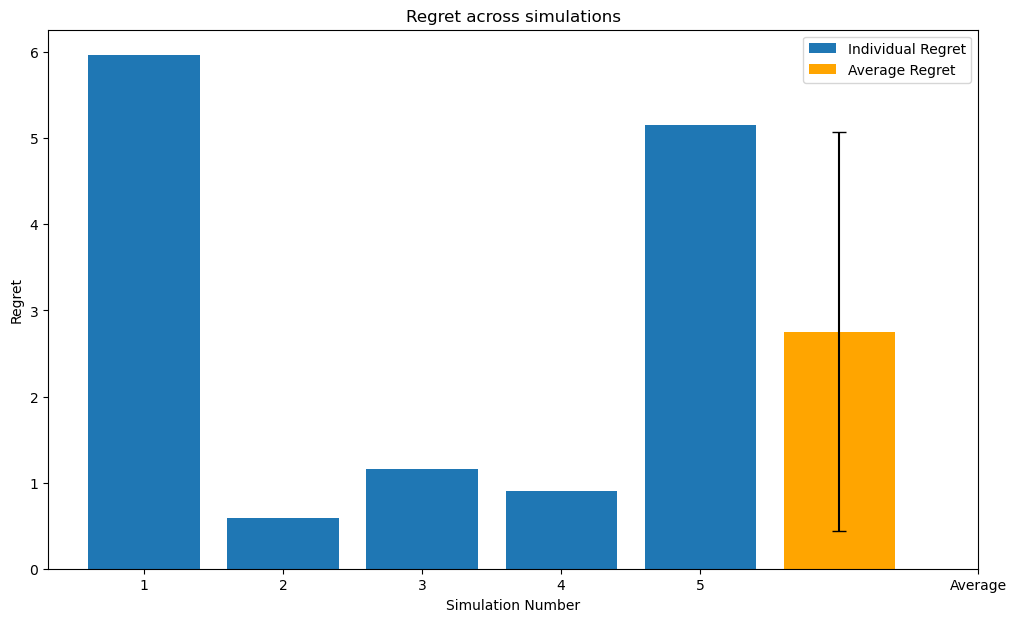

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Get the regret 
regret = np.array(overall_results_online) - np.array(overall_results_offline)
# Average and standard deviation of the regret 
avg_regret = np.mean(regret)
std_regret = np.std(regret)

# Get the number of simulations
num_simulations = len(regret)
simulation_numbers = list(range(1, num_simulations + 1))

plt.figure(figsize=(12, 7))
plt.bar(simulation_numbers, regret, capsize=5, label='Individual Regret')
plt.bar([num_simulations + 1], [avg_regret], yerr=[std_regret], capsize=5, color='orange', label='Average Regret')
plt.title('Regret across simulations')
plt.xlabel('Simulation Number')
plt.ylabel('Regret')
plt.xticks(simulation_numbers + [num_simulations + 2], labels=simulation_numbers + ['Average'])
y_min = min(regret.min(), avg_regret - std_regret)
y_max = max(regret.max(), avg_regret + std_regret)
plt.legend()
plt.show()
